In [47]:
 # Parameters
dataset_path = "default_value.csv"

In [48]:
# import os
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, random_split
# from torch.utils.data.sampler import WeightedRandomSampler
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder  # Added import for LabelEncoder
# from collections import Counter

In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter

# Step 1: Load and Preprocess Data
def load_data(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    return data

def preprocess_data(data, label_col='label'):
    # Drop missing values
    data = data.dropna()

    # Encode categorical 'protocol' column if exists
    if 'protocol' in data.columns:
        le_protocol = LabelEncoder()
        data['protocol'] = le_protocol.fit_transform(data['protocol'])

    # Encode labels
    label_encoder = LabelEncoder()
    data[label_col] = label_encoder.fit_transform(data[label_col].values)
    classes = label_encoder.classes_

    # Identify features
    feature_columns = data.columns.difference([label_col]).tolist()
    return data, feature_columns, label_encoder

# Step 2: PyTorch Dataset
class DDoSDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx].unsqueeze(0), self.labels[idx]  # Add channel dimension


# Step 3: Load Data, Split, and Scale
# Load dataset
data = load_data(dataset_path)

# Preprocess dataset
data, feature_columns, label_encoder = preprocess_data(data, label_col='label')

# Split dataset (70% Train, 15% Validation, 15% Test)
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Separate features and labels
X_train = train_data[feature_columns].values
y_train = train_data['label'].values

X_val = val_data[feature_columns].values
y_val = val_data['label'].values

X_test = test_data[feature_columns].values
y_test = test_data['label'].values

# **Scale data using StandardScaler**
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on train
X_val = scaler.transform(X_val)          # Transform validation
X_test = scaler.transform(X_test)        # Transform test

# **Fix class imbalance with WeightedRandomSampler**
class_counts = Counter(y_train)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# **Create PyTorch Datasets**
train_dataset = DDoSDataset(X_train, y_train)
val_dataset = DDoSDataset(X_val, y_val)
test_dataset = DDoSDataset(X_test, y_test)

# **Use Weighted Sampler in Train Loader**
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 4: Define Improved 1D CNN Model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)  # Batch Normalization
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

        # Adjust the input size based on pooling layers
        self.fc1 = nn.Linear(128 * (input_size // 8), 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), 0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), 0.01))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), 0.01))

        x = x.view(x.size(0), -1)  
        x = self.dropout(F.leaky_relu(self.fc1(x), 0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), 0.01))
        x = self.fc3(x)
        return x


# Step 5: Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)

model = CNN1D(input_size, num_classes).to(device)

# **Apply Xavier Initialization**
def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)

# **Use Lower Learning Rate**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Step 6: Training Loop with Gradient Clipping
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()

            # **Apply Gradient Clipping**
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()

        # **Validation Step**
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100.0 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Accuracy: {val_accuracy:.2f}%")

    return model

# **Train the Model**
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Epoch [1/10] | Train Loss: 0.0102 | Val Loss: 0.0032 | Val Accuracy: 99.92%
Epoch [2/10] | Train Loss: 0.0025 | Val Loss: 0.0048 | Val Accuracy: 99.91%
Epoch [3/10] | Train Loss: 0.0021 | Val Loss: 0.0042 | Val Accuracy: 99.93%
Epoch [4/10] | Train Loss: 0.0018 | Val Loss: 0.0033 | Val Accuracy: 99.94%


In [ ]:
# Step 7: Evaluate on Test Data
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# **Evaluate the Model**
evaluate_model(model, test_loader, device)

In [32]:
# # Step 1: Load the CSV dataset
# def load_data(csv_path):
#     data = pd.read_csv(csv_path, low_memory=False)
#     data = data.sample(frac=1, random_state=42)  # Shuffle data
#     return data

# # Step 2: Prepare the dataset for 1D CNN
# from sklearn.preprocessing import LabelEncoder
# import numpy as np

# # Step 2: Prepare the dataset for 1D CNN
# def prepare_data(data):
#     # Drop rows with missing values
#     data = data.dropna()
    
#     label_col = 'label'

#     # Encode the 'protocol' column if it exists
#     if 'protocol' in data.columns:
#         le = LabelEncoder()
#         data['protocol'] = le.fit_transform(data['protocol'])

#     # Define feature columns (all columns except the label)
#     feature_columns = data.columns.difference([label_col]).tolist()

#     # Convert features to float32
#     features = data[feature_columns].values.astype(np.float32)

#     # Encode labels as integers and capture all unique classes
#     label_encoder = LabelEncoder()
#     labels = label_encoder.fit_transform(data[label_col].values)
#     classes = label_encoder.classes_
    
#     return features, labels, classes


# # Step 3: Create a custom PyTorch Dataset class
# class DDoSDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = torch.tensor(features, dtype=torch.float32)
#         self.labels = torch.tensor(labels, dtype=torch.long)
    
#     def __len__(self):
#         return len(self.features)
    
#     def __getitem__(self, idx):
#         return self.features[idx].unsqueeze(0), self.labels[idx]  # Add channel dimension

In [33]:
# # Step 4: Load data, split into train, validation, and test sets
# data = load_data("/Users/book_kuno/Desktop/ddos_datasets copy/2018.csv")
# features, labels, classes = prepare_data(data)

# # First split: 70% for training, 30% for validation + test
# train_feats, temp_feats, train_labels, temp_labels = train_test_split(
#     features, labels, test_size=0.3, random_state=42
# )

# # Second split: Split 30% into 15% validation and 15% test
# val_feats, test_feats, val_labels, test_labels = train_test_split(
#     temp_feats, temp_labels, test_size=0.5, random_state=42
# )

# # Handle class imbalance using WeightedRandomSampler
# class_counts = Counter(train_labels)
# class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
# weights = [class_weights[label] for label in train_labels]
# sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# # Create DataLoaders
# train_dataset = DDoSDataset(train_feats, train_labels)
# val_dataset = DDoSDataset(val_feats, val_labels)
# test_dataset = DDoSDataset(test_feats, test_labels)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
# # Step 5: Define the 1D CNN model
# class CNN1D(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(CNN1D, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(32 * (input_size // 2 // 2), 64)
#         self.fc2 = nn.Linear(64, num_classes)
    
#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [35]:
# # Step 6: Initialize model, loss, and optimizer
# input_size = features.shape[1]
# num_classes = len(set(labels))

# model = CNN1D(input_size, num_classes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [36]:
# # Step 7: Train the model with validation
# def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
#     for epoch in range(epochs):
#         model.train()
#         total_loss = 0
#         for features, labels in train_loader:
#             features, labels = features.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         # Validation step
#         model.eval()
#         val_loss = 0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for features, labels in val_loader:
#                 features, labels = features.to(device), labels.to(device)
#                 outputs = model(features)
#                 val_loss += criterion(outputs, labels).item()
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
        
#         val_accuracy = 100 * correct / total
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

#     return model

# model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Loss: 1154.0620, Validation Loss: 1.3083, Validation Accuracy: 55.56%
Epoch 2/50, Loss: 1.3079, Validation Loss: 1.3084, Validation Accuracy: 55.56%
Epoch 3/50, Loss: 1.3079, Validation Loss: 1.3088, Validation Accuracy: 55.56%


KeyboardInterrupt: 

In [ ]:
# # Step 8: Evaluate on test data
# def evaluate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     y_true = []  # To store true labels
#     y_pred = []  # To store predicted labels

#     with torch.no_grad():
#         for features, labels in test_loader:
#             features, labels = features.to(device), labels.to(device)
#             outputs = model(features)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             # Append the current batch's true and predicted labels to the lists
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())

#     print(f"Test Accuracy: {100 * correct / total:.2f}%")
#     return y_true, y_pred

# # Get the true and predicted labels
# y_true, y_pred = evaluate_model(model, test_loader)

Test Accuracy: 55.54%


In [ ]:
#V1:Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.71    361511
           1       0.00      0.00      0.00    102708
           2       0.00      0.00      0.00       278
           3       0.00      0.00      0.00     86728
           4       0.00      0.00      0.00      7598
           5       0.00      0.00      0.00     69082
           6       0.00      0.00      0.00     21062
           7       0.00      0.00      0.00      1980
           8       0.00      0.00      0.00         1

    accuracy                           0.56    650948
   macro avg       0.06      0.11      0.08    650948
weighted avg       0.31      0.56      0.40    650948



/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


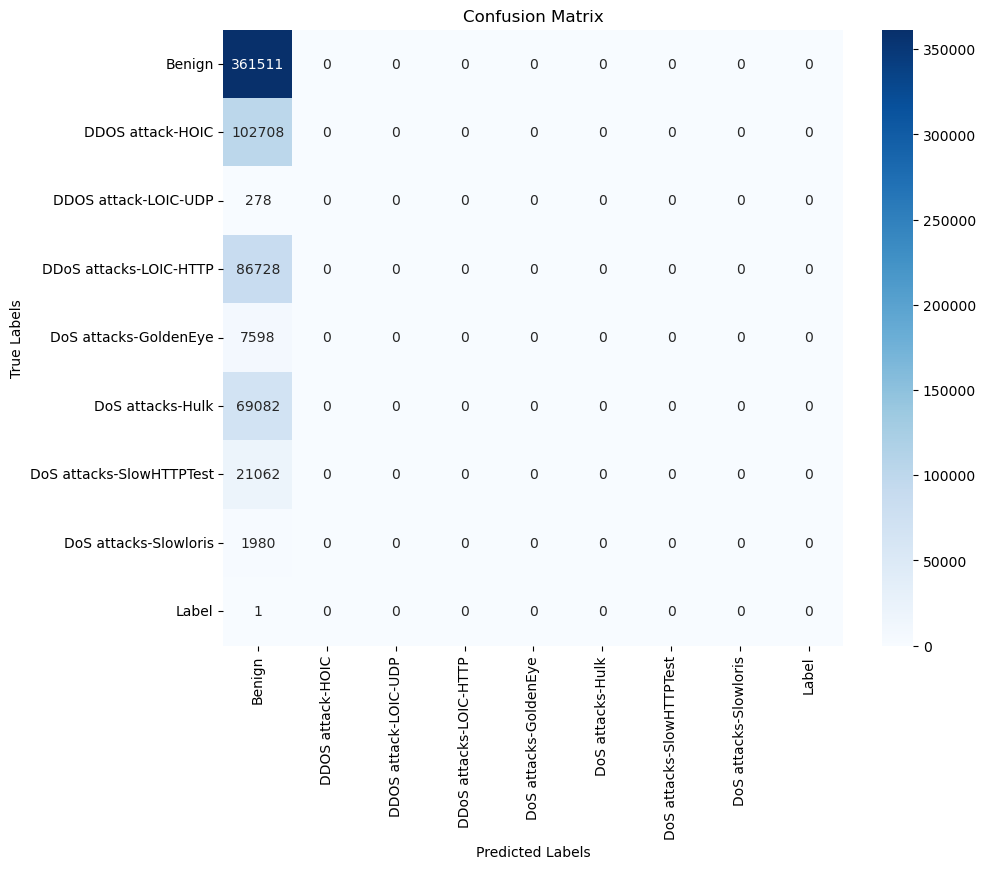

In [ ]:
#V2:Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are your true labels and predictions respectively,
# and that you retrieved the classes from prepare_data.
# For example:
# features, labels, classes = prepare_data(data)
# ... train your model, then:
# y_pred = model.predict(X_test)
# and you have y_true from the test split.

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


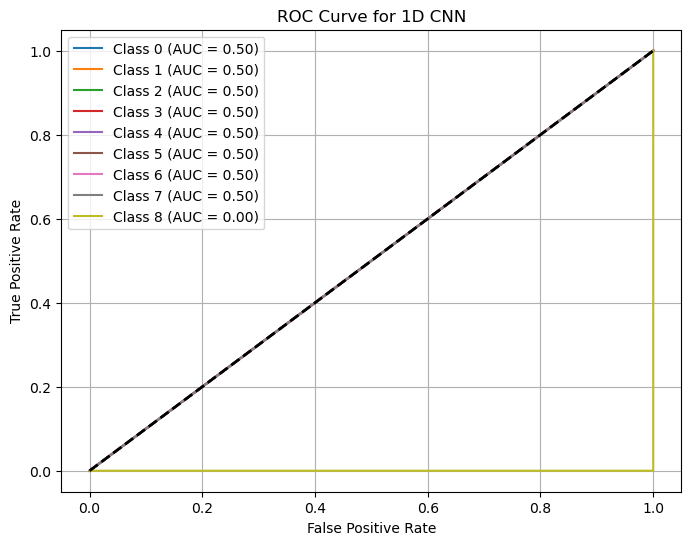

In [ ]:
#V3: ROC Curve
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def get_predictions_and_probabilities(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get model predictions (logits)
            prob = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            y_true.extend(labels.cpu().numpy())  # Append ground truth labels
            y_pred_prob.extend(prob.cpu().numpy())  # Append predicted probabilities

    y_pred_prob = np.array(y_pred_prob)
    return y_true, y_pred_prob

# Get true labels and predicted probabilities
y_true, y_pred_prob = get_predictions_and_probabilities(model, test_loader, device)

# Dynamically generate class names based on the number of classes
n_classes = y_pred_prob.shape[1]
class_names = [f"Class {i}" for i in range(n_classes)]

plt.figure(figsize=(8, 6))

# Loop over each class and calculate the ROC curve
for i in range(n_classes):
    # Calculate ROC curve for class i
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line representing random classifier
plt.title("ROC Curve for 1D CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()